<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 50px"><b>But de ce Notebook</b></h2>
<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Dans ce notebook, nous implémenterons plusieurs modèles prédictifs pour prédire la sinistralité, et nous comparerons entre eux.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Définition de la sinistralité</b></h2>

<p style="font-family: Arial, sans-serif; font-size: 20px; color:white;">
En nous inspirant de la bibliographie 2, nous définissons le ratio de sinistralité de la façon suivante:</p>

$$
\text{dérive de sinistralité(N/N-1)} = \frac{RAC_{N}}{RAC_{N-1}} -1\\

\text{où $RAC_{N}$ est le reste à charge par personne à l'année N}\\

\text{et $RAC_{N-1}$ est le reste à charge par personne à l'année N-1}
$$


<p style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Librairies nécessaires</p>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import sklearn as sklearn
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm for the progress bar
import itertools


<p style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Helper Functions</p>

In [3]:
def ajouter_harmoniques_mensuelles(df, nb_harmoniques=2):
    """
    Ajoute des composantes sinusoïdales au DataFrame pour modéliser la cyclicité mensuelle.
    
    Paramètres :
    - df : DataFrame contenant une colonne de mois (1 à 12)
    - col_mois : nom de la colonne contenant les mois
    - nb_harmoniques : nombre d'harmoniques à ajouter (>=1)
    
    Retour :
    - df enrichi de colonnes sin/cos pour chaque harmonique
    """
    for k in range(1, nb_harmoniques + 1):
        df[f'{'mois'}_sin_{k}'] = np.sin(2 * np.pi * k * df['mois'] / 12)
        df[f'{'mois'}_cos_{k}'] = np.cos(2 * np.pi * k * df['mois'] / 12)
    return df

<p style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px">Importation des données</p>

In [4]:
SIN_df = pd.read_csv("DBs/SIN_df.csv", index_col=0)
SIN_df.columns 

Index(['annee', 'mois', 'region', 'SIN_N/N-1'], dtype='object')

<p style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 30px; font-weight: bold">Visualisation de la dérive</p>

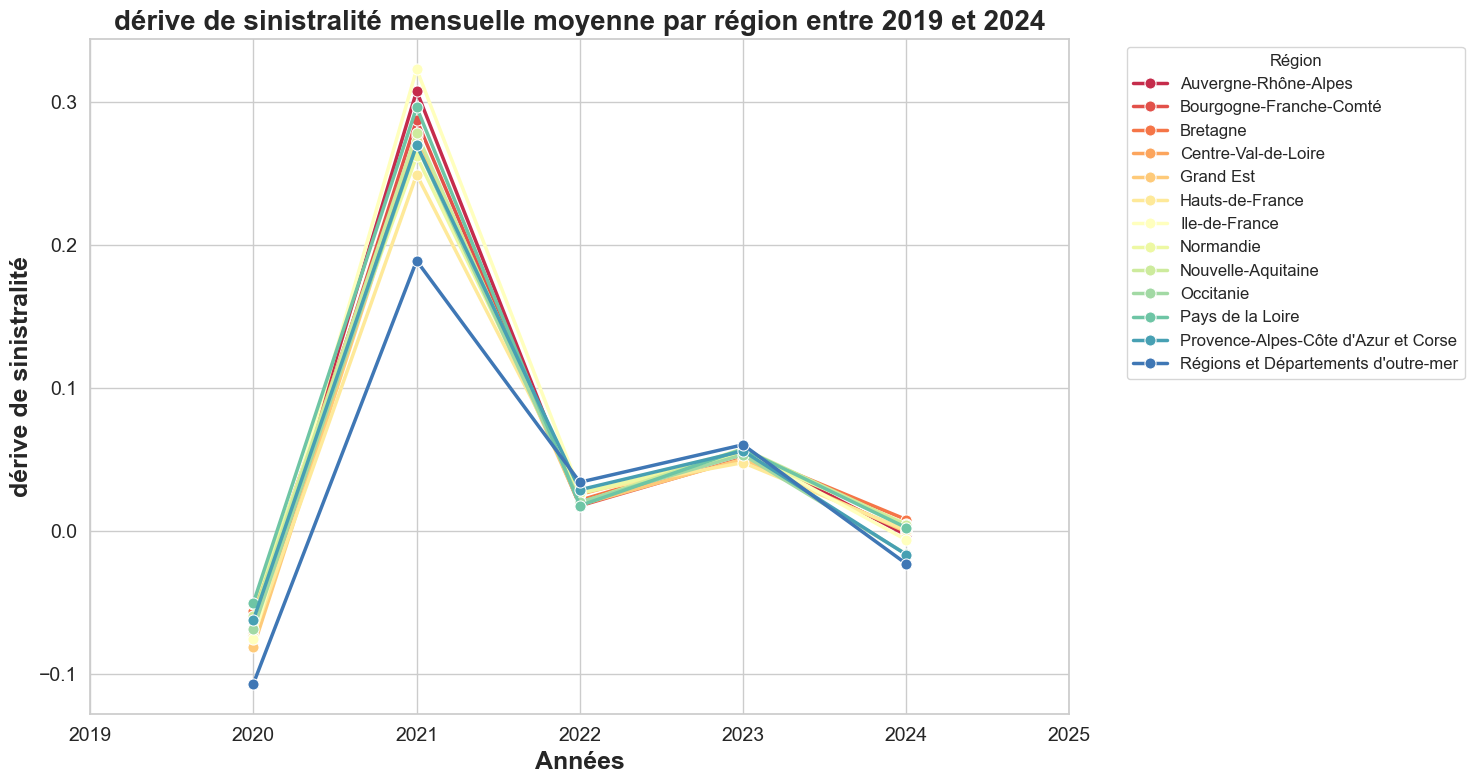

In [5]:
# Définir le style de la visualisation
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Tracer une courbe pour visualiser le reste à charge (RAC) par région entre 2019 et 2024
sns.lineplot(
    x="annee",  # Axe des x : années
    y="SIN_N/N-1",  # Axe des y : reste à charge (RAC)
    data=SIN_df,  # Données utilisées pour la visualisation
    hue="region",  # Différencier les courbes par région
    marker='o',  # Ajouter des marqueurs pour chaque point
    markersize=8,  # Taille des marqueurs
    linewidth=2.5,  # Épaisseur des lignes
    errorbar=None,  # Pas de barres d'erreur
    estimator=np.mean,  # Estimation basée sur la somme des valeurs
    palette="Spectral"  # Palette de couleurs pour différencier les régions
)

# Ajouter un titre avec une taille de police plus grande
plt.title("dérive de sinistralité mensuelle moyenne par région entre 2019 et 2024", fontsize=20, fontweight='bold')

# Ajouter des étiquettes aux axes avec une taille de police plus grande
plt.xlabel("Années", fontsize=18, fontweight='bold')
plt.ylabel("dérive de sinistralité", fontsize=18, fontweight='bold')

# Ajuster la taille des ticks des axes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Ajuster les limites de l'axe des x pour inclure les années de 2018 à 2025
plt.xlim(2019, 2025)

# Placer la légende en dehors du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Région", fontsize=12)

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()

C:\Users\Ouarhim Younes\AppData\Local\Temp\ipykernel_7616\2612337898.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


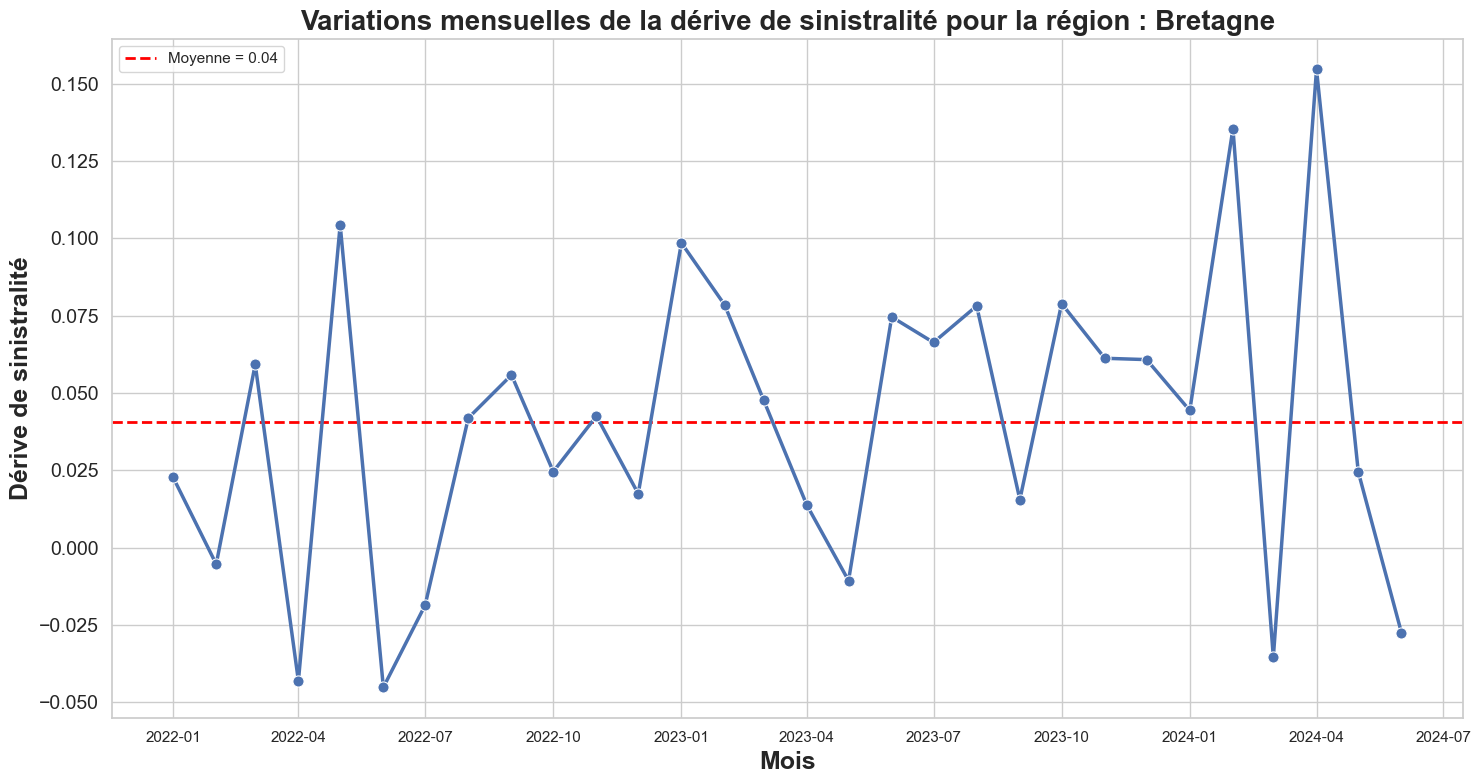

In [29]:
def tracer_variations_mensuelles(region_name):
    """
    Trace les variations mensuelles de la dérive de sinistralité pour une région donnée.

    Paramètres :
    - region_name : Nom de la région à visualiser (str)
    """
    # Filtrer les données pour la région spécifiée et les années entre 2020 et 2024
    region_df = SIN_df[SIN_df['region'] == region_name].copy()




    region_df['date'] = pd.to_datetime(dict(year=region_df['annee'], month=region_df['mois'], day=1))


    region_df = region_df[(region_df['date'] >= pd.Timestamp('2022-01-01')) & (region_df['date'] <= pd.Timestamp('2024-06-01'))] 


    # Définir le style de la visualisation
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 8))

    # Calculer la moyenne du champ SIN_N/N-1
    moyenne_sin = region_df['SIN_N/N-1'].mean()

    # Ajouter une droite horizontale à la valeur moyenne
    plt.axhline(y=moyenne_sin, color='red', linestyle='--', linewidth=2, label=f"Moyenne = {moyenne_sin:.2f}")
    plt.legend(fontsize=14)

    # Tracer une courbe pour visualiser les variations mensuelles
    sns.lineplot(
        x="date",  # Axe des x : mois
        y="SIN_N/N-1",  # Axe des y : dérive de sinistralité
        data=region_df,  # Données utilisées pour la visualisation
        marker='o',  # Ajouter des marqueurs pour chaque point
        markersize=8,  # Taille des marqueurs
        linewidth=2.5,  # Épaisseur des lignes
        palette="tab10"  # Palette de couleurs
    )

    # Ajouter un titre avec une taille de police plus grande
    plt.title(f"Variations mensuelles de la dérive de sinistralité pour la région : {region_name}", fontsize=20, fontweight='bold')

    # Ajouter des étiquettes aux axes avec une taille de police plus grande
    plt.xlabel("Mois", fontsize=18, fontweight='bold')
    plt.ylabel("Dérive de sinistralité", fontsize=18, fontweight='bold')

    # Ajuster les ticks des axes
    plt.yticks(fontsize=14)

    # Placer la légende en dehors du graphique

    # Ajuster la disposition pour éviter le chevauchement
    plt.tight_layout()

    # Afficher le graphique
    plt.show()

# Exemple d'utilisation
# choix possible de régions
region_mapping = {
    5: "Régions et Départements d'outre-mer",
    11: "Ile-de-France",
    24: "Centre-Val-de-Loire",
    27: "Bourgogne-Franche-Comté",
    28: "Normandie",
    32: "Hauts-de-France",
    44: "Grand Est",
    52: "Pays de la Loire",
    53: "Bretagne",
    75: "Nouvelle-Aquitaine",
    76: "Occitanie",
    84: "Auvergne-Rhône-Alpes",
    93: "Provence-Alpes-Côte d'Azur et Corse"
}
tracer_variations_mensuelles("Bretagne")

<p style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 30px; font-weight: bold">Implémentation d'un arbre de décision</p>

In [7]:
df = SIN_df.copy()

region = pd.DataFrame(df[df['annee'] == 2024]['region'].copy())

#df = df[df['region'] == "Occitanie"].drop(columns="region") 
df = pd.get_dummies(df, columns= ['region'], dtype=int)



df['nombre du mois'] = df['mois'] + 12*(df['annee'] - 2020)

df = ajouter_harmoniques_mensuelles(df, 20)

train = df[(df["annee"] >= 2020) & (df["annee"] < 2024)]
test = df[df["annee"] == 2024]



X_train = train.drop(columns=['SIN_N/N-1'])
y_train = train['SIN_N/N-1']
X_test = test.drop(columns=['SIN_N/N-1'])
y_test = test['SIN_N/N-1']


# Define the parameter grid
param_grid = {
    'max_depth': [3, 5],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [3, 5, 10],
    'max_leaf_nodes': [5, 10, 20, 30, 50]
}



def get_best_parameter_combination(param_grid=param_grid):
    best_model = None
    best_parameters = {}
    best_MAPE = np.inf
    for (max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes) in itertools.product(*list(param_grid.values())):
        # Entraînement de l'arbre
        model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes)
        model.fit(X_train, y_train)

        # Prédictions
        y_pred = model.predict(X_test)

        # évaluation du modèle
        MAPE = sklearn.metrics.mean_absolute_percentage_error(y_pred, y_test)
        if MAPE * 100 < best_MAPE :
            best_model = model
            best_parameters = {
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_leaf_nodes': max_leaf_nodes
                }
            best_MAPE = round(MAPE * 100,2)
    return best_MAPE, best_parameters, best_model
        

In [8]:
best_MAPE, best_parameters, best_model = get_best_parameter_combination()

print(f"Le meilleur modèle a une MAPE de validation égale à : {best_MAPE}% pour les paramètres suivants : {best_parameters}.")

# Combine predictions with test data
pd.concat([X_test[['annee', 'mois']].reset_index(drop=True), region.reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(best_model.predict(X_test)).reset_index(drop=True).rename({0: "predited SIN_N/N-1"}, axis=1)], axis=1)

Le meilleur modèle a une MAPE de validation égale à : 176.08% pour les paramètres suivants : {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_leaf_nodes': 10}.


,annee,mois,region,SIN_N/N-1,predited SIN_N/N-1
0,2024,1,Auvergne-Rhône-Alpes,0.034682,0.049858
1,2024,2,Auvergne-Rhône-Alpes,0.111150,0.049858
2,2024,3,Auvergne-Rhône-Alpes,-0.021767,0.049858
3,2024,4,Auvergne-Rhône-Alpes,0.117056,0.049858
4,2024,5,Auvergne-Rhône-Alpes,0.020239,0.049858
...,...,...,...,...,...
151,2024,8,Régions et Départements d'outre-mer,-0.018827,0.049858
152,2024,9,Régions et Départements d'outre-mer,-0.026820,0.049858
153,2024,10,Régions et Départements d'outre-mer,-0.023457,0.049858
154,2024,11,Régions et Départements d'outre-mer,-0.157017,0.049858


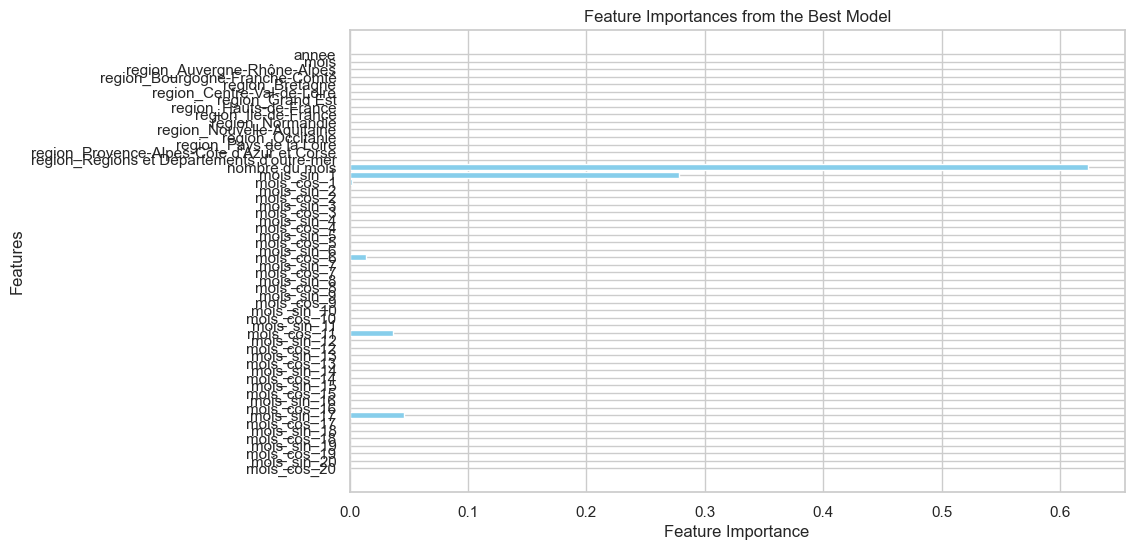

In [9]:
import matplotlib.pyplot as plt

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Get feature names from the training data
feature_names = X_train.columns

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from the Best Model')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

**Remarque:** On remarque que la MAPE obtenu en utilisant un arbre de décision est très mauvaise 164 % sur les données de validation (données de dérive pour 2024), donc on doit choisir un modèle plus complexe.

<p style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 30px; font-weight: bold">On va essayer d'implémenter des méthodes d'ensemble pour bien prédire la sinistralité</p>

<p style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px; font-weight: bold">Random Forest</p>

In [10]:
df = SIN_df.copy()

region = pd.DataFrame(df[df['annee'] == 2024]['region'].copy())


df = pd.get_dummies(df, columns= ['region'], dtype=int)

df['nombre du mois'] = df['mois'] + 12*(df['annee'] - 2020)

df = ajouter_harmoniques_mensuelles(df, 20)


train = df[(df["annee"] < 2024)]
test = df[df["annee"] == 2024]

X_train = train.drop(columns=['SIN_N/N-1'])
y_train = train['SIN_N/N-1']
X_test = test.drop(columns=['SIN_N/N-1'])
y_test = test['SIN_N/N-1']


# Instantiate the Random Forest Regressor with default parameters
# Define a dictionary with multiple values for the parameters to try
param_grid = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    #'criterion': ['absolute_error', 'squared_error'],  # Function to measure the quality of a split
    'max_depth': [3, 5, 7, 10, 15],  # Maximum depth of the tree
    #'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3, 5],  # Minimum number of samples required to be at a leaf node
    'max_leaf_nodes': [10, 20, 30, 50, 100],  # Maximum number of leaf nodes
    'bootstrap': [True]  # Whether bootstrap samples are used when building trees
}

def get_best_parameter_combination_rf(param_grid=param_grid):
    best_model = None
    best_parameters = {}
    best_MAPE = np.inf
    

    # Calculate the total number of combinations
    total_combinations = len(list(itertools.product(*list(param_grid.values()))))

    # Iterate through the parameter combinations with a progress bar
    for (n_estimators, max_depth, min_samples_leaf,  max_leaf_nodes, bootstrap) in tqdm(itertools.product(*list(param_grid.values())), total=total_combinations, desc="Grid Search Progress"):
        # Entraînement de l'arbre
        model = RandomForestRegressor(n_estimators= n_estimators, max_depth= max_depth, min_samples_leaf= min_samples_leaf, max_leaf_nodes = max_leaf_nodes, bootstrap= bootstrap)
        model.fit(X_train, y_train)

        # Prédictions
        y_pred = model.predict(X_test)

        # évaluation du modèle
        MAPE = sklearn.metrics.mean_absolute_percentage_error(y_pred, y_test)
        if MAPE * 100 < best_MAPE :
            best_model = model
            best_parameters = {
            'n_estimators': n_estimators,  # Number of trees in the forest
            #'criterion': criterion,  # Function to measure the quality of a split
            'max_depth': max_depth,  # Maximum depth of the tree
            #'min_samples_split': min_samples_split,  # Minimum number of samples required to split an internal node
            'min_samples_leaf': min_samples_leaf,  # Minimum number of samples required to be at a leaf node
            'max_leaf_nodes': max_leaf_nodes,  # Maximum number of leaf nodes
        }
            best_MAPE = round(MAPE * 100,2)
    return best_MAPE, best_parameters, best_model




In [11]:
best_MAPE, best_parameters, best_model = get_best_parameter_combination_rf()

print(f"Le meilleur modèle a une MAPE de validation égale à : {best_MAPE}% pour les paramètres suivants : {best_parameters}.")

# Combine predictions with test data
pd.concat([X_test[['annee', 'mois']].reset_index(drop=True), region.reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(best_model_xgb.predict(X_test)).reset_index(drop=True).rename({0: "predited SIN_N/N-1"}, axis=1)], axis=1)

Grid Search Progress: 100%|██████████| 225/225 [01:15<00:00,  2.99it/s]


Le meilleur modèle a une MAPE de validation égale à : 149.3% pour les paramètres suivants : {'n_estimators': 10, 'max_depth': 10, 'min_samples_leaf': 3, 'max_leaf_nodes': 20}.


NameError: name 'best_model_xgb' is not defined

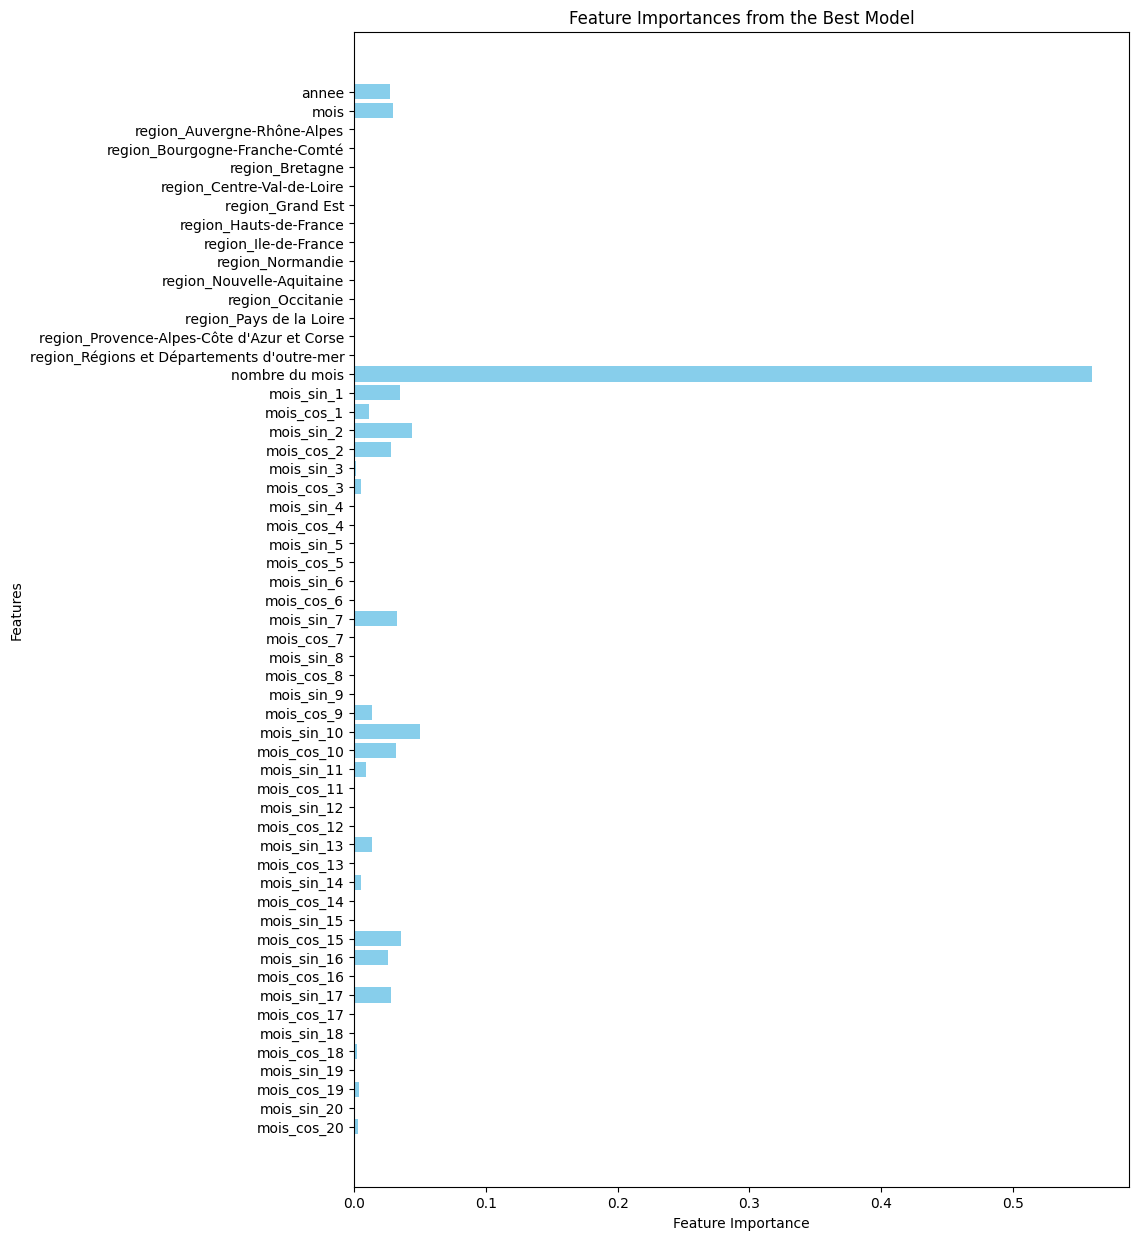

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Get feature names from the training data
feature_names = X_train.columns

# Create a bar plot
plt.figure(figsize=(10, 15))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from the Best Model')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

<p style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px; font-weight: bold">XGBoost</p>

In [ ]:
df = SIN_df.copy()

region = pd.DataFrame(df[df['annee'] == 2024]['region'].copy())


df = pd.get_dummies(df, columns= ['region'], dtype=int)



df['nombre du mois'] = df['mois'] + 12*(df['annee'] - 2020)

df = ajouter_harmoniques_mensuelles(df, 2)


train = df[(df["annee"] < 2024)]
test = df[df["annee"] == 2024]

X_train = train.drop(columns=['SIN_N/N-1'])
y_train = train['SIN_N/N-1']
X_test = test.drop(columns=['SIN_N/N-1'])
y_test = test['SIN_N/N-1']

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

def get_best_parameter_combination_xgb(param_grid=param_grid_xgb):
    best_model = None
    best_parameters = {}
    best_MAPE = np.inf

    # Calculate the total number of combinations
    total_combinations = len(list(itertools.product(*list(param_grid.values()))))

    # Iterate through the parameter combinations with a progress bar
    for (n_estimators, max_depth, learning_rate, subsample, colsample_bytree) in tqdm(
        itertools.product(*list(param_grid.values())), 
        total=total_combinations, 
        desc="Grid Search Progress (XGBoost)"
    ):
        # Train the XGBoost model
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42
        )
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Evaluate the model
        MAPE = sklearn.metrics.mean_absolute_percentage_error(y_pred, y_test)
        if MAPE * 100 < best_MAPE:
            best_model = model
            best_parameters = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'learning_rate': learning_rate,
                'subsample': subsample,
                'colsample_bytree': colsample_bytree
            }
            best_MAPE = round(MAPE * 100, 2)
    return best_MAPE, best_parameters, best_model

# Find the best XGBoost model
best_MAPE_xgb, best_parameters_xgb, best_model_xgb = get_best_parameter_combination_xgb()

print(f"Le meilleur modèle XGBoost a une MAPE de validation égale à : {best_MAPE_xgb}% pour les paramètres suivants : {best_parameters_xgb}.")

# Combine predictions with test data
pd.concat([X_test[['annee', 'mois']].reset_index(drop=True), region.reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(best_model_xgb.predict(X_test)).reset_index(drop=True).rename({0: "predited SIN_N/N-1"}, axis=1)], axis=1)

Grid Search Progress (XGBoost):   0%|          | 0/36 [00:00<?, ?it/s]

Grid Search Progress (XGBoost): 100%|██████████| 36/36 [00:10<00:00,  3.44it/s]

Le meilleur modèle XGBoost a une MAPE de validation égale à : 143.26% pour les paramètres suivants : {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 1.0}.


,annee,mois,region,SIN_N/N-1,predited SIN_N/N-1
0,2024,1,Auvergne-Rhône-Alpes,0.034682,0.083524
1,2024,2,Auvergne-Rhône-Alpes,0.111150,0.066493
2,2024,3,Auvergne-Rhône-Alpes,-0.021767,0.074758
3,2024,4,Auvergne-Rhône-Alpes,0.117056,0.074758
4,2024,5,Auvergne-Rhône-Alpes,0.020239,0.074758
...,...,...,...,...,...
151,2024,8,Régions et Départements d'outre-mer,-0.018827,0.069387
152,2024,9,Régions et Départements d'outre-mer,-0.026820,0.060356
153,2024,10,Régions et Départements d'outre-mer,-0.023457,0.063480
154,2024,11,Régions et Départements d'outre-mer,-0.157017,0.073999


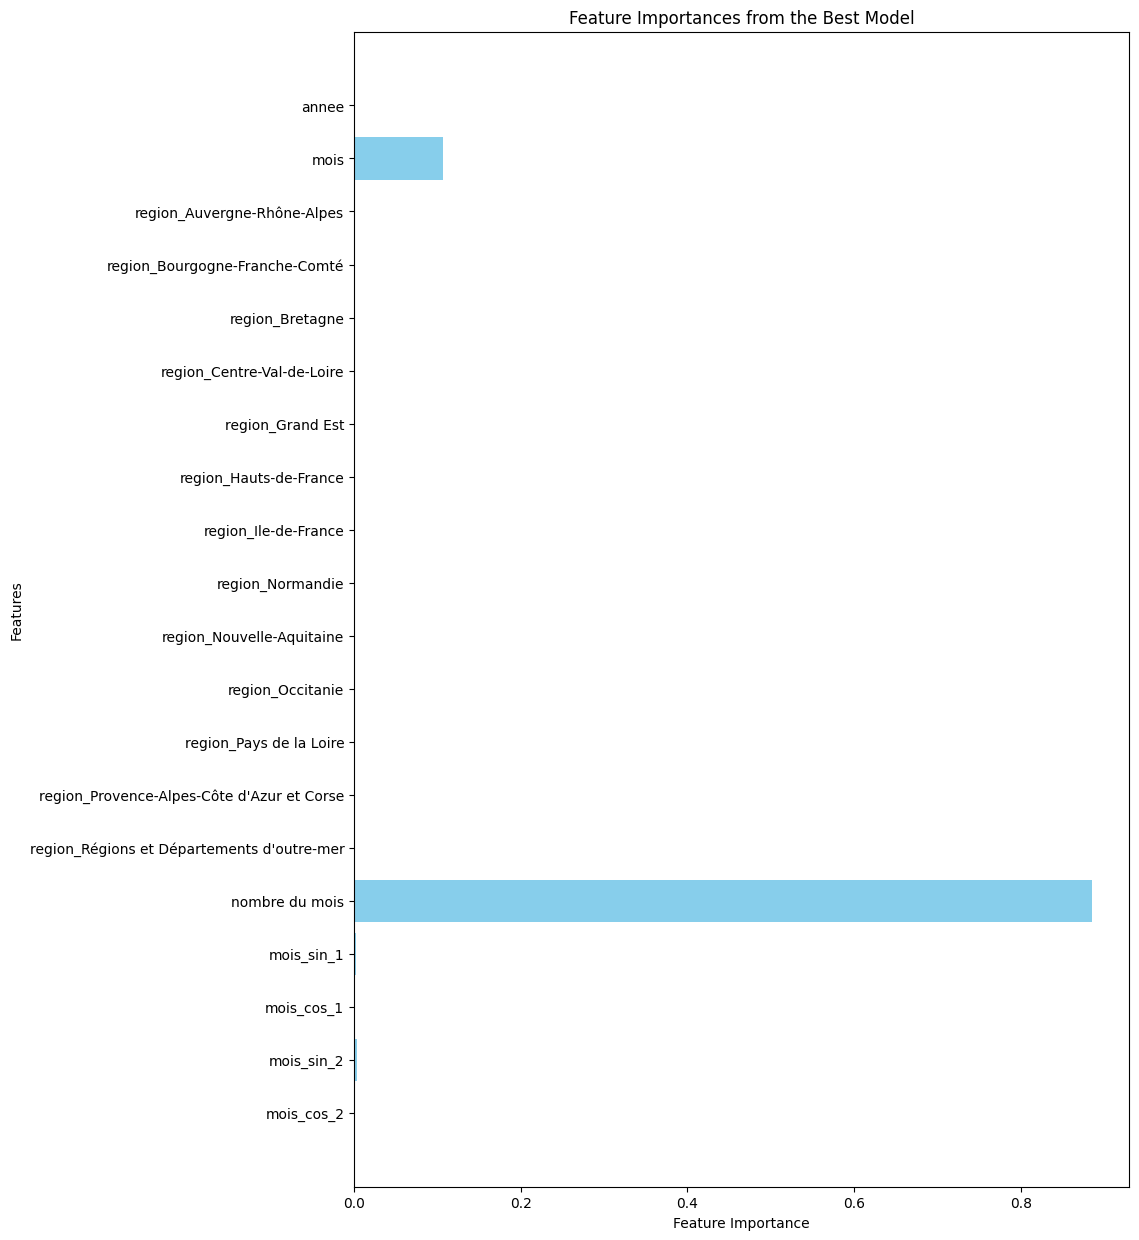

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from the best model
feature_importances = best_model_xgb.feature_importances_

# Get feature names from the training data
feature_names = X_train.columns

# Create a bar plot
plt.figure(figsize=(10, 15))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from the Best Model')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

**Remarque:** Je remarque que vu que je n'ai pas assez de features, les arbres de décision répetent la même logique pour faire les splits des. C'est pourquoi je vais passer à un autre types de modèle accés surtout sur les séries temporelles : **ARIMA et LSTM et Prophet**. 

<p style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 30px; font-weight: bold">On va coder le modèle ARIMA</p>